# CAE-MLP Model Analysis for Cylinder Flow

This notebook provides a comprehensive analysis of the trained CAE-MLP model on the Cylinder flow dataset.
The Cylinder dataset contains 2D flow around a cylinder at different Reynolds numbers.

## Contents:
1. Load trained model and configuration
2. Training history analysis
3. Flow reconstruction quality evaluation
4. Multi-case generalization analysis
5. Latent space analysis for different flow regimes
6. Prediction accuracy assessment
7. Reynolds number sensitivity analysis
8. Vortex shedding dynamics capture
9. Long-term prediction stability

In [1]:
# %% Import libraries
import os
import sys
import json
import yaml
import numpy as np
import torch
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import scipy.signal

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

from src.models.CAE_MLP.caemlp import CAE_LinearMLP, CAE_WeakLinearMLP
from src.models.CAE_MLP.utils import create_caemlp_dataloaders, reshape_data_for_cae

# Set plotting parameters
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Load Model and Configuration

CAE_LinearMLP

In [4]:
# %% Load configuration and model - CAE_LinearMLP Only
# Specify the experiment folder for CAE_LinearMLP
experiment_folder = "results/checkpoints/CAE_MLP/cylinder_CAE_LinearMLP_multiply_large_epoch"
experiment_path = Path(project_root) / experiment_folder

print(f"Loading CAE_LinearMLP experiment from: {experiment_path}")

# Load configuration
config_path = experiment_path / "config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Verify model type
assert config['model']['type'] == 'CAE_LinearMLP', f"Expected CAE_LinearMLP but got {config['model']['type']}"

print("\nConfiguration:")
print(f"Model type: {config['model']['type']}")
print(f"Training mode: {config['training']['train_mode']}")
print(f"Latent dimension: {config['model']['params']['latent_dim']}")

# Load training history
history_path = experiment_path / "training_history.json"
with open(history_path, 'r') as f:
    history = json.load(f)

# Load losses
losses_path = experiment_path / "losses" / "losses.json"
with open(losses_path, 'r') as f:
    losses_data = json.load(f)

# Create CAE_LinearMLP model
model_params = config['model']['params']
model = CAE_LinearMLP(
    input_channels=2,
    input_shape=(64, 64),
    **model_params
)

# Initialize model by running a dummy forward pass
dummy_input = torch.randn(1, 2, 64, 64)
with torch.no_grad():
    _ = model(dummy_input)

# Load best checkpoint
checkpoint_path = experiment_path / "checkpoints" / "best_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"\nModel loaded from epoch: {checkpoint.get('epoch', 'N/A')}")
if 'best_val_loss' in checkpoint:
    print(f"Best validation loss: {checkpoint.get('best_val_loss', 'N/A'):.6f}")
else:
    # For multiply training mode, the best loss might be in stage3
    if 'train_losses_stage3' in checkpoint:
        final_val_loss = checkpoint['val_losses_stage3']['total'][-1]
        print(f"Final validation loss (Stage 3): {final_val_loss:.6f}")

Loading CAE_LinearMLP experiment from: /rds/general/user/wy524/home/ESEProjects/IRP/irp-test-framework/results/checkpoints/CAE_MLP/cylinder_CAE_LinearMLP_multiply_large_epoch

Configuration:
Model type: CAE_LinearMLP
Training mode: multiply
Latent dimension: 64

Model loaded from epoch: 500
Final validation loss (Stage 3): 1.066317


#### CAE_WeakLinearMLP

In [5]:
# %% Load configuration and model - CAE_WeakLinearMLP Only
# Specify the experiment folder for CAE_WeakLinearMLP
experiment_folder = "results/checkpoints/CAE_MLP/cylinder_CAE_WeakLinearMLP_multiply_large_epoch"
experiment_path = Path(project_root) / experiment_folder

print(f"Loading CAE_WeakLinearMLP experiment from: {experiment_path}")

# Load configuration
config_path = experiment_path / "config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Verify model type
assert config['model']['type'] == 'CAE_WeakLinearMLP', f"Expected CAE_WeakLinearMLP but got {config['model']['type']}"

print("\nConfiguration:")
print(f"Model type: {config['model']['type']}")
print(f"Training mode: {config['training']['train_mode']}")
print(f"Latent dimension: {config['model']['params']['latent_dim']}")

# Load training history
history_path = experiment_path / "training_history.json"
with open(history_path, 'r') as f:
    history = json.load(f)

# Load losses
losses_path = experiment_path / "losses" / "losses.json"
with open(losses_path, 'r') as f:
    losses_data = json.load(f)

# Create CAE_WeakLinearMLP model
model_params = config['model']['params']
model = CAE_WeakLinearMLP(
    input_channels=2,
    input_shape=(64, 64),
    **model_params
)

model.eval()

# Initialize model by running a dummy forward pass
dummy_input = torch.randn(1, 2, 64, 64)
with torch.no_grad():
    _ = model(dummy_input)

# Load best checkpoint - handle different training modes
checkpoint_path = experiment_path / "checkpoints" / "best_checkpoint.pth"
if not checkpoint_path.exists():
    # For multiply mode, might be saved differently
    checkpoint_path = experiment_path / "checkpoints" / "latest_checkpoint_final.pth"

checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

# Try loading state dict with error handling
try:
    model.load_state_dict(checkpoint['model_state_dict'])
except RuntimeError as e:
    print(f"Warning: Error loading state dict: {e}")
    print("Attempting to load with strict=False...")
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)

model.eval()

print(f"\nModel loaded from epoch: {checkpoint.get('epoch', 'N/A')}")
if 'best_val_loss' in checkpoint:
    print(f"Best validation loss: {checkpoint.get('best_val_loss', 'N/A'):.6f}")
else:
    # For multiply training mode, the best loss might be in stage3
    if 'train_losses_stage3' in checkpoint:
        final_val_loss = checkpoint['val_losses_stage3']['total'][-1]
        print(f"Final validation loss (Stage 3): {final_val_loss:.6f}")

Loading CAE_WeakLinearMLP experiment from: /rds/general/user/wy524/home/ESEProjects/IRP/irp-test-framework/results/checkpoints/CAE_MLP/cylinder_CAE_WeakLinearMLP_multiply_large_epoch

Configuration:
Model type: CAE_WeakLinearMLP
Training mode: multiply
Latent dimension: 64

Model loaded from epoch: 2357
Final validation loss (Stage 3): 1.015221


## 2. Training History Analysis

In [6]:
# %% Plot training history
def plot_training_history_cylinder(losses_data, config):
    """Plot training history for different training modes"""
    train_mode = config['training']['train_mode']
    
    if train_mode == 'separately':
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Stage 1: CAE reconstruction
        ax = axes[0]
        train_recon = losses_data['train_losses']['stage1']['reconstruction']
        val_recon = losses_data['val_losses']['stage1']['reconstruction']
        ax.plot(train_recon, label='Train', linewidth=2)
        ax.plot(val_recon, label='Validation', linewidth=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Reconstruction Loss')
        ax.set_title('Stage 1: CAE Reconstruction Training')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
        
        # Stage 2: Linear predictor
        ax = axes[1]
        train_pred = losses_data['train_losses']['stage2']['prediction']
        val_pred = losses_data['val_losses']['stage2']['prediction']
        ax.plot(train_pred, label='Train', linewidth=2)
        ax.plot(val_pred, label='Validation', linewidth=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Prediction Loss')
        ax.set_title('Stage 2: Linear Predictor Training')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
        
    elif train_mode == 'jointly':
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        losses_to_plot = ['total', 'reconstruction', 'prediction', 'latent_reg']
        titles = ['Total Loss', 'Reconstruction Loss', 'Prediction Loss', 'Latent Regularization']
        
        for idx, (loss_key, title) in enumerate(zip(losses_to_plot, titles)):
            ax = axes[idx // 2, idx % 2]
            if loss_key in losses_data['train_losses']:
                train_loss = losses_data['train_losses'][loss_key]
                val_loss = losses_data['val_losses'][loss_key]
                ax.plot(train_loss, label='Train', linewidth=2)
                ax.plot(val_loss, label='Validation', linewidth=2)
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Loss')
                ax.set_title(title)
                ax.legend()
                ax.grid(True, alpha=0.3)
                ax.set_yscale('log')
    
    plt.suptitle(f'Training History - {train_mode.capitalize()} Mode', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_training_history_cylinder(losses_data, config)


<Figure size 1200x800 with 0 Axes>

## 3. Load Test Data and Evaluate Flow Reconstruction

Case case0001: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0002: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0003: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0004: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0005: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0006: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0007: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0008: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0009: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0010: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0011: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0012: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0013: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0014: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0015: u shape = (1000, 64, 64), v shape = (1000, 64, 64)
Case case0

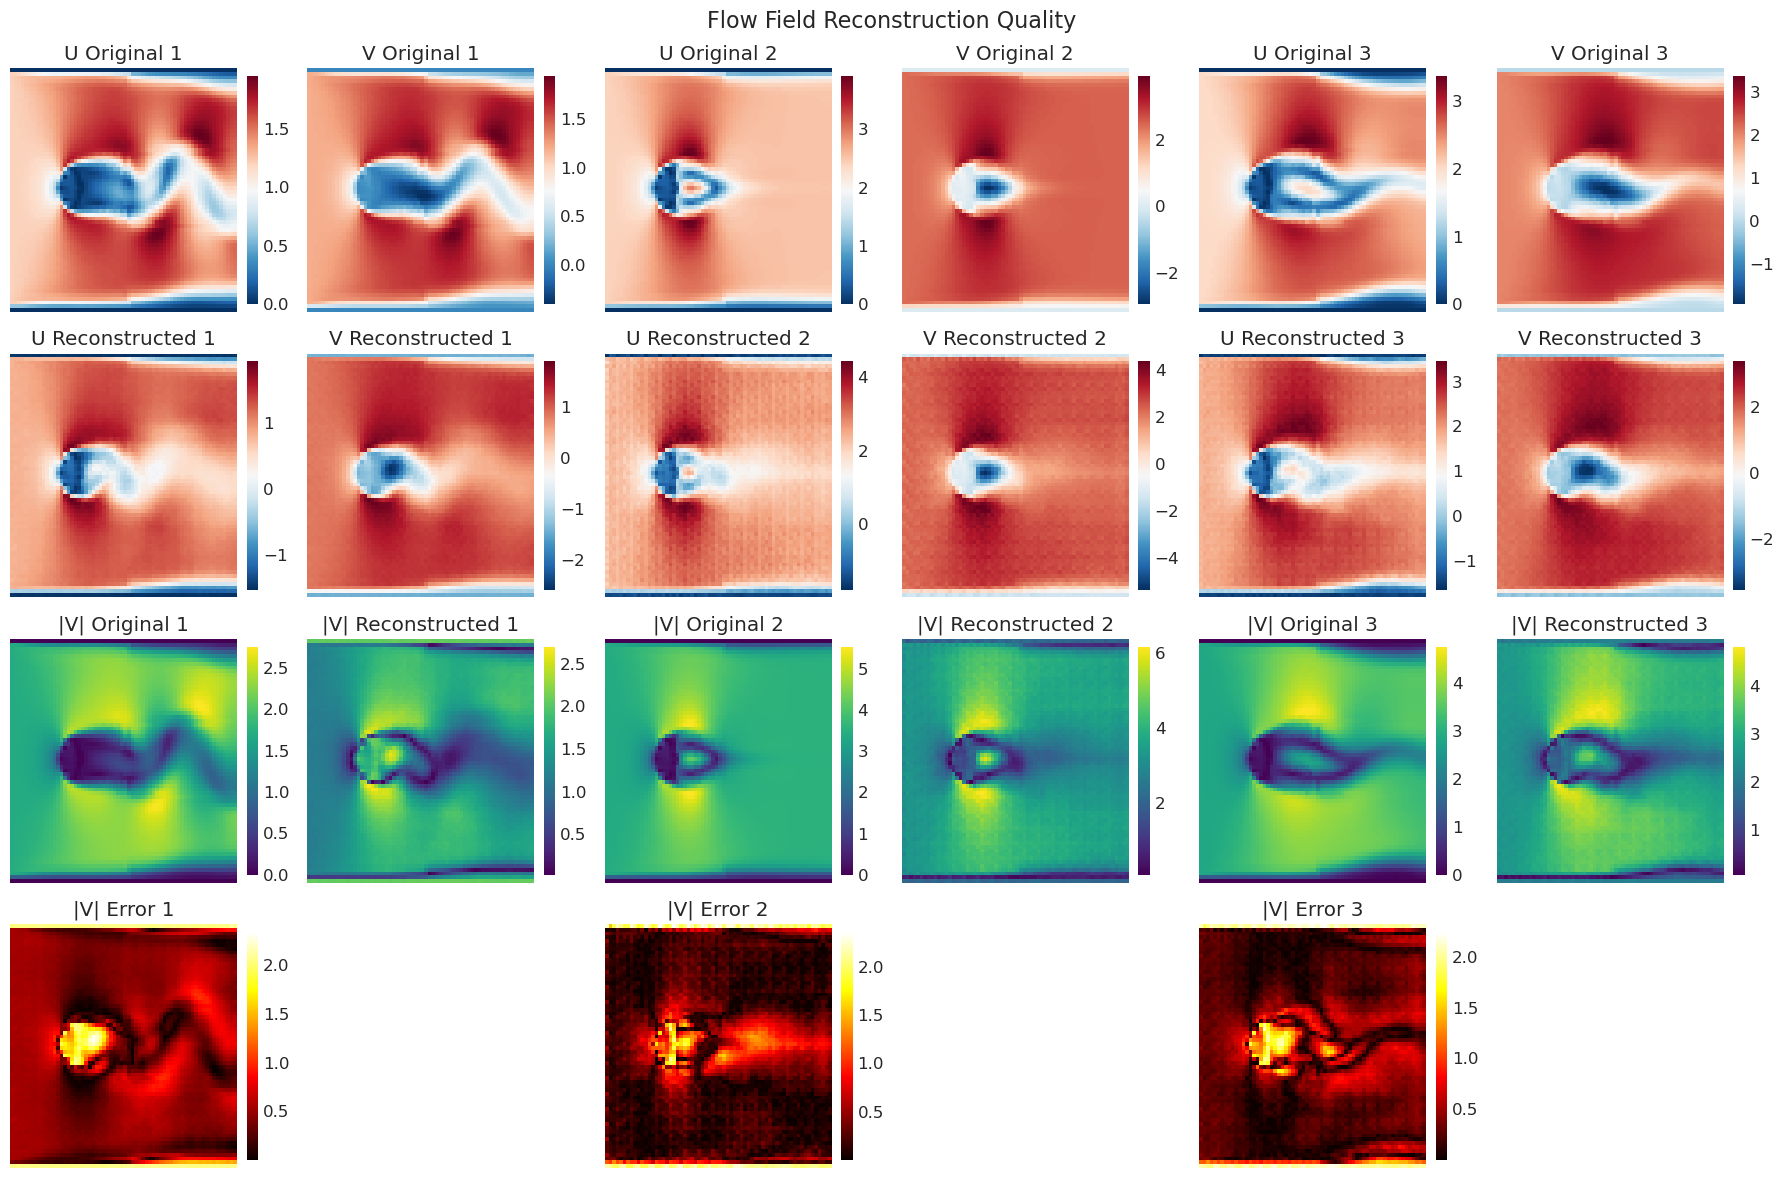


Reconstruction Metrics:
U-component MSE: 0.361334
V-component MSE: 0.327784
Total MSE: 0.344559
Relative Error: 18.9404%


In [7]:
# %% Load test data
# Create data loaders
config['dataset']['data_path'] = str(project_root / 'data')
train_loader, val_loader, data_info = create_caemlp_dataloaders(config['dataset'])

print(f"Data shape: {data_info['batch_shape']}")
print(f"Number of channels: {data_info['num_channels']}")
print(f"Number of validation samples: {data_info['dataset_size_val']}")

# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Get a batch of validation data
with torch.no_grad():
    for x_t, x_next in val_loader:
        x_t = x_t.to(device)
        x_next = x_next.to(device)
        
        # Reshape for CAE
        x_t_cae = reshape_data_for_cae(x_t, 'cylinder', target_shape=target_resolution)
        x_next_cae = reshape_data_for_cae(x_next, 'cylinder', target_shape=target_resolution)
        
        # Get model outputs
        if isinstance(model, CAE_WeakLinearMLP):
            x_t_recon, x_next_pred, z_t, z_next, z_next_linear = model(x_t_cae)
        else:
            x_t_recon, x_next_pred, z_t, z_next = model(x_t_cae)
        
        break

# %% Visualize flow reconstruction
def visualize_flow_reconstruction(x_true, x_recon, n_samples=3):
    """Visualize original vs reconstructed flow fields (u and v components)"""
    fig, axes = plt.subplots(4, n_samples*2, figsize=(n_samples*6, 12))
    
    for i in range(n_samples):
        # U-component
        # Original
        im = axes[0, i*2].imshow(x_true[i, 0].cpu().numpy(), cmap='RdBu_r', aspect='auto')
        axes[0, i*2].set_title(f'U Original {i+1}')
        axes[0, i*2].axis('off')
        plt.colorbar(im, ax=axes[0, i*2], fraction=0.046, pad=0.04)
        
        # Reconstructed
        im = axes[1, i*2].imshow(x_recon[i, 0].cpu().numpy(), cmap='RdBu_r', aspect='auto')
        axes[1, i*2].set_title(f'U Reconstructed {i+1}')
        axes[1, i*2].axis('off')
        plt.colorbar(im, ax=axes[1, i*2], fraction=0.046, pad=0.04)
        
        # V-component
        # Original
        im = axes[0, i*2+1].imshow(x_true[i, 1].cpu().numpy(), cmap='RdBu_r', aspect='auto')
        axes[0, i*2+1].set_title(f'V Original {i+1}')
        axes[0, i*2+1].axis('off')
        plt.colorbar(im, ax=axes[0, i*2+1], fraction=0.046, pad=0.04)
        
        # Reconstructed
        im = axes[1, i*2+1].imshow(x_recon[i, 1].cpu().numpy(), cmap='RdBu_r', aspect='auto')
        axes[1, i*2+1].set_title(f'V Reconstructed {i+1}')
        axes[1, i*2+1].axis('off')
        plt.colorbar(im, ax=axes[1, i*2+1], fraction=0.046, pad=0.04)
        
        # Velocity magnitude
        mag_true = np.sqrt(x_true[i, 0].cpu().numpy()**2 + x_true[i, 1].cpu().numpy()**2)
        mag_recon = np.sqrt(x_recon[i, 0].cpu().numpy()**2 + x_recon[i, 1].cpu().numpy()**2)
        
        im = axes[2, i*2].imshow(mag_true, cmap='viridis', aspect='auto')
        axes[2, i*2].set_title(f'|V| Original {i+1}')
        axes[2, i*2].axis('off')
        plt.colorbar(im, ax=axes[2, i*2], fraction=0.046, pad=0.04)
        
        im = axes[2, i*2+1].imshow(mag_recon, cmap='viridis', aspect='auto')
        axes[2, i*2+1].set_title(f'|V| Reconstructed {i+1}')
        axes[2, i*2+1].axis('off')
        plt.colorbar(im, ax=axes[2, i*2+1], fraction=0.046, pad=0.04)
        
        # Error magnitude
        error_mag = np.abs(mag_true - mag_recon)
        im = axes[3, i*2:i*2+2].flatten()[0].imshow(error_mag, cmap='hot', aspect='auto')
        axes[3, i*2:i*2+2].flatten()[0].set_title(f'|V| Error {i+1}')
        axes[3, i*2:i*2+2].flatten()[0].axis('off')
        plt.colorbar(im, ax=axes[3, i*2:i*2+2].flatten()[0], fraction=0.046, pad=0.04)
        
        # Remove unused axis
        axes[3, i*2+1].remove()
    
    plt.suptitle('Flow Field Reconstruction Quality', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics
    mse_u = nn.MSELoss()(x_true[:, 0], x_recon[:, 0]).item()
    mse_v = nn.MSELoss()(x_true[:, 1], x_recon[:, 1]).item()
    mse_total = nn.MSELoss()(x_true, x_recon).item()
    
    print(f"\nReconstruction Metrics:")
    print(f"U-component MSE: {mse_u:.6f}")
    print(f"V-component MSE: {mse_v:.6f}")
    print(f"Total MSE: {mse_total:.6f}")
    print(f"Relative Error: {torch.norm(x_true - x_recon) / torch.norm(x_true):.4%}")

visualize_flow_reconstruction(x_t_cae, x_t_recon, n_samples=3)

## 4. Vorticity Analysis

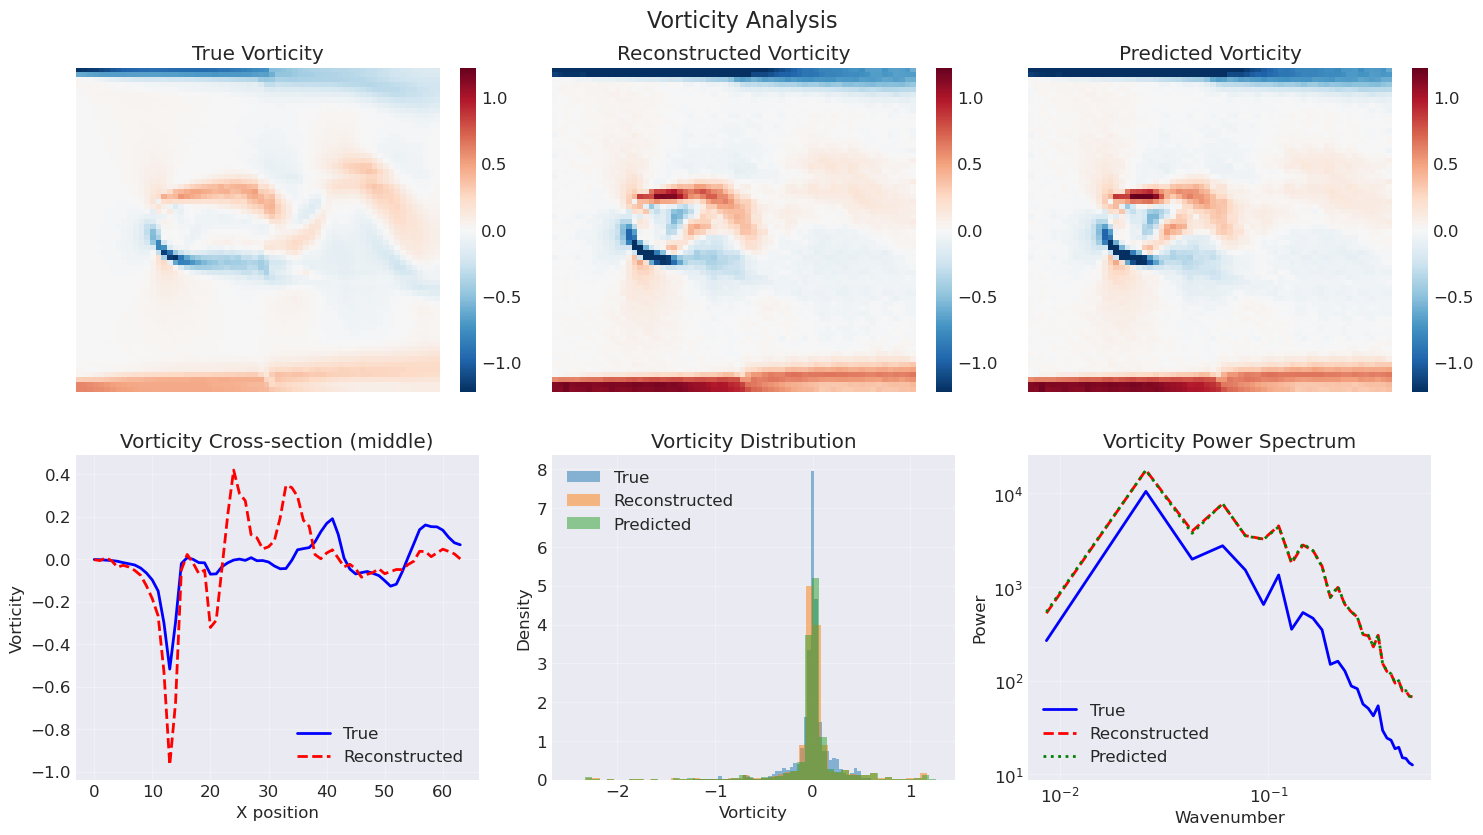


Vorticity Preservation:
Reconstruction relative error: 108.2607%
Prediction relative error: 108.7881%


In [8]:
# %% Analyze vorticity
def compute_vorticity(u, v, dx=1.0, dy=1.0):
    """Compute vorticity from velocity components"""
    # Compute gradients
    dv_dx = np.gradient(v, dx, axis=-1)
    du_dy = np.gradient(u, dy, axis=-2)
    
    # Vorticity = dv/dx - du/dy
    vorticity = dv_dx - du_dy
    return vorticity

def analyze_vorticity(x_true, x_recon, x_pred):
    """Analyze vorticity preservation"""
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    
    # Select one sample
    u_true = x_true[0, 0].cpu().numpy()
    v_true = x_true[0, 1].cpu().numpy()
    u_recon = x_recon[0, 0].cpu().numpy()
    v_recon = x_recon[0, 1].cpu().numpy()
    u_pred = x_pred[0, 0].cpu().numpy()
    v_pred = x_pred[0, 1].cpu().numpy()
    
    # Compute vorticity
    vort_true = compute_vorticity(u_true, v_true)
    vort_recon = compute_vorticity(u_recon, v_recon)
    vort_pred = compute_vorticity(u_pred, v_pred)
    
    # Plot vorticity fields
    vmax = np.abs(vort_true).max()
    
    im1 = axes[0, 0].imshow(vort_true, cmap='RdBu_r', vmin=-vmax, vmax=vmax, aspect='auto')
    axes[0, 0].set_title('True Vorticity')
    axes[0, 0].axis('off')
    plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)
    
    im2 = axes[0, 1].imshow(vort_recon, cmap='RdBu_r', vmin=-vmax, vmax=vmax, aspect='auto')
    axes[0, 1].set_title('Reconstructed Vorticity')
    axes[0, 1].axis('off')
    plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)
    
    im3 = axes[0, 2].imshow(vort_pred, cmap='RdBu_r', vmin=-vmax, vmax=vmax, aspect='auto')
    axes[0, 2].set_title('Predicted Vorticity')
    axes[0, 2].axis('off')
    plt.colorbar(im3, ax=axes[0, 2], fraction=0.046)
    
    # Plot cross-sections
    mid_y = vort_true.shape[0] // 2
    axes[1, 0].plot(vort_true[mid_y, :], 'b-', label='True', linewidth=2)
    axes[1, 0].plot(vort_recon[mid_y, :], 'r--', label='Reconstructed', linewidth=2)
    axes[1, 0].set_xlabel('X position')
    axes[1, 0].set_ylabel('Vorticity')
    axes[1, 0].set_title('Vorticity Cross-section (middle)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Vorticity statistics
    axes[1, 1].hist(vort_true.flatten(), bins=50, alpha=0.5, label='True', density=True)
    axes[1, 1].hist(vort_recon.flatten(), bins=50, alpha=0.5, label='Reconstructed', density=True)
    axes[1, 1].hist(vort_pred.flatten(), bins=50, alpha=0.5, label='Predicted', density=True)
    axes[1, 1].set_xlabel('Vorticity')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].set_title('Vorticity Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Power spectrum of vorticity
    fft_true = np.fft.fft2(vort_true)
    fft_recon = np.fft.fft2(vort_recon)
    fft_pred = np.fft.fft2(vort_pred)
    
    power_true = np.abs(fft_true)**2
    power_recon = np.abs(fft_recon)**2
    power_pred = np.abs(fft_pred)**2
    
    # Radial average
    kx = np.fft.fftfreq(vort_true.shape[1])
    ky = np.fft.fftfreq(vort_true.shape[0])
    k = np.sqrt(kx[None, :]**2 + ky[:, None]**2)
    
    # Bin by wavenumber
    k_bins = np.linspace(0, 0.5, 30)
    power_binned_true = []
    power_binned_recon = []
    power_binned_pred = []
    
    for i in range(len(k_bins)-1):
        mask = (k >= k_bins[i]) & (k < k_bins[i+1])
        if mask.sum() > 0:
            power_binned_true.append(power_true[mask].mean())
            power_binned_recon.append(power_recon[mask].mean())
            power_binned_pred.append(power_pred[mask].mean())
    
    k_centers = (k_bins[:-1] + k_bins[1:]) / 2
    k_centers = k_centers[:len(power_binned_true)]
    
    axes[1, 2].loglog(k_centers, power_binned_true, 'b-', label='True', linewidth=2)
    axes[1, 2].loglog(k_centers, power_binned_recon, 'r--', label='Reconstructed', linewidth=2)
    axes[1, 2].loglog(k_centers, power_binned_pred, 'g:', label='Predicted', linewidth=2)
    axes[1, 2].set_xlabel('Wavenumber')
    axes[1, 2].set_ylabel('Power')
    axes[1, 2].set_title('Vorticity Power Spectrum')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    # Remove unused axes
    for ax in axes[2, :]:
        ax.remove()
    
    plt.suptitle('Vorticity Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Compute errors
    vort_error_recon = np.mean((vort_true - vort_recon)**2) / np.mean(vort_true**2)
    vort_error_pred = np.mean((vort_true - vort_pred)**2) / np.mean(vort_true**2)
    
    print(f"\nVorticity Preservation:")
    print(f"Reconstruction relative error: {np.sqrt(vort_error_recon):.4%}")
    print(f"Prediction relative error: {np.sqrt(vort_error_pred):.4%}")

analyze_vorticity(x_t_cae, x_t_recon, x_next_pred)

## 5. Latent Space Analysis for Different Flow Cases

Latent codes shape: (10, 64)
Number of unique cases: 1


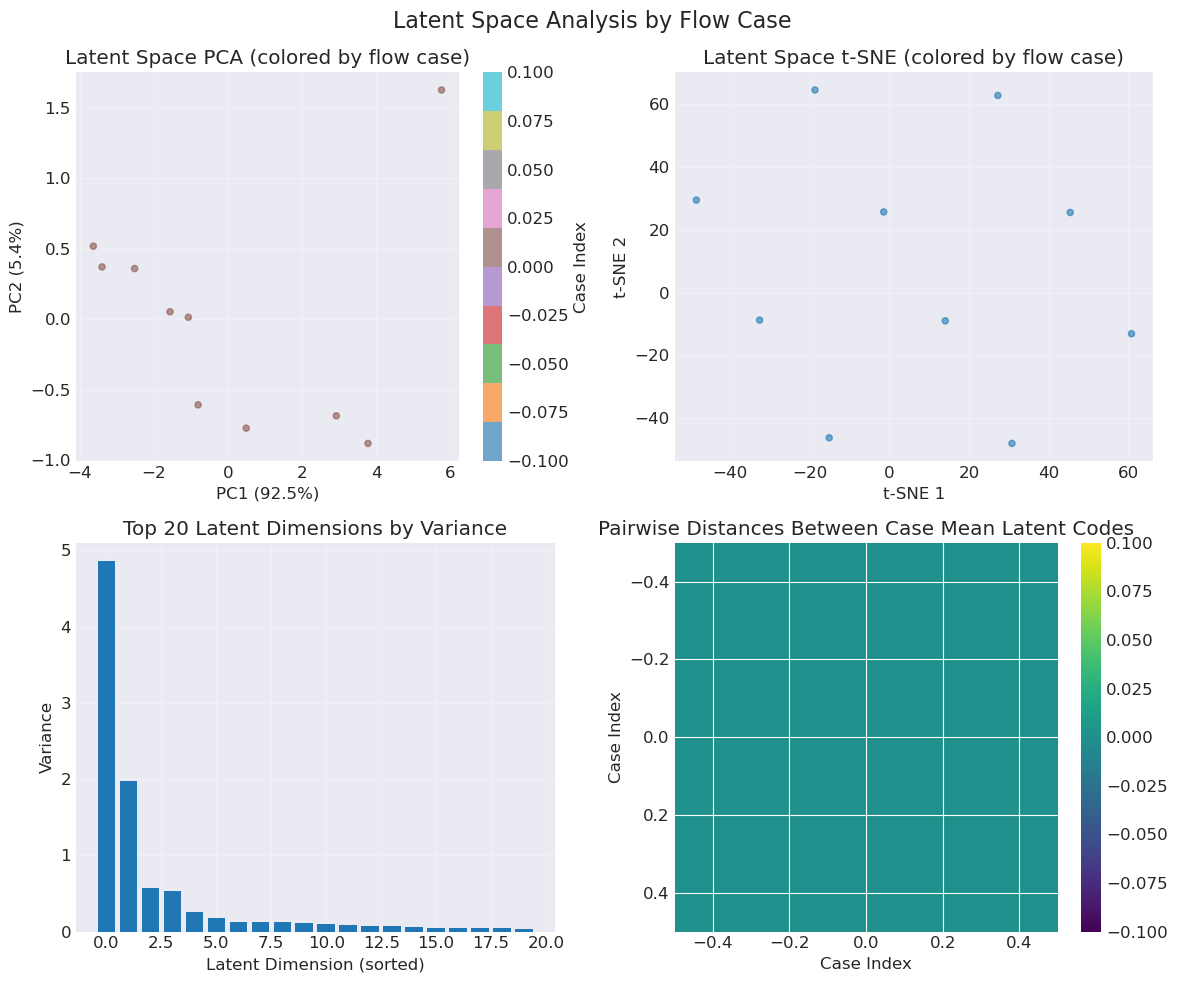

In [11]:
# %% Analyze latent space across different Reynolds numbers
def analyze_latent_space_by_case(model, val_loader, device, n_batches=20):
    """Analyze latent representations for different flow cases"""
    latent_codes = []
    case_indices = []
    
    model.eval()
    with torch.no_grad():
        for i, (x_t, _) in enumerate(val_loader):
            if i >= n_batches:
                break
                
            x_t = x_t.to(device)
            x_t_cae = reshape_data_for_cae(x_t, 'cylinder', target_shape=target_resolution)
            
            # Encode
            z_t = model.cae.encode(x_t_cae)
            latent_codes.append(z_t.cpu().numpy())
            
            # Track which case each sample belongs to
            # Assuming samples are ordered by case
            case_indices.extend([i // (len(val_loader.dataset) // 10) for _ in range(len(z_t))])
    
    latent_codes = np.concatenate(latent_codes, axis=0)
    case_indices = np.array(case_indices[:len(latent_codes)])
    
    return latent_codes, case_indices

# Get latent codes
latent_codes, case_indices = analyze_latent_space_by_case(model, val_loader, device)
print(f"Latent codes shape: {latent_codes.shape}")
print(f"Number of unique cases: {len(np.unique(case_indices))}")

# Visualize latent space
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# PCA visualization colored by case
ax = axes[0, 0]
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_codes)

scatter = ax.scatter(latent_pca[:, 0], latent_pca[:, 1], 
                    c=case_indices, cmap='tab10', alpha=0.6, s=20)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('Latent Space PCA (colored by flow case)')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Case Index')

# t-SNE visualization
ax = axes[0, 1]
tsne = TSNE(n_components=2, random_state=42, perplexity=9)
latent_tsne = tsne.fit_transform(latent_codes[:500])  # Use subset for speed
case_subset = case_indices[:500]

scatter = ax.scatter(latent_tsne[:, 0], latent_tsne[:, 1], 
                    c=case_subset, cmap='tab10', alpha=0.6, s=20)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('Latent Space t-SNE (colored by flow case)')
ax.grid(True, alpha=0.3)

# Latent dimension importance
ax = axes[1, 0]
latent_var = np.var(latent_codes, axis=0)
sorted_indices = np.argsort(latent_var)[::-1]
ax.bar(range(min(20, len(latent_var))), latent_var[sorted_indices[:20]])
ax.set_xlabel('Latent Dimension (sorted)')
ax.set_ylabel('Variance')
ax.set_title('Top 20 Latent Dimensions by Variance')
ax.grid(True, alpha=0.3)

# Case separation in latent space
ax = axes[1, 1]
# Compute mean latent code for each case
unique_cases = np.unique(case_indices)
case_means = []
for case in unique_cases:
    case_mask = case_indices == case
    case_mean = latent_codes[case_mask].mean(axis=0)
    case_means.append(case_mean)

case_means = np.array(case_means)

# Compute pairwise distances
from scipy.spatial.distance import pdist, squareform
pairwise_distances = squareform(pdist(case_means))

im = ax.imshow(pairwise_distances, cmap='viridis', aspect='auto')
ax.set_xlabel('Case Index')
ax.set_ylabel('Case Index')
ax.set_title('Pairwise Distances Between Case Mean Latent Codes')
plt.colorbar(im, ax=ax)

plt.suptitle('Latent Space Analysis by Flow Case', fontsize=16)
plt.tight_layout()
plt.show()

## 6. Temporal Dynamics Analysis

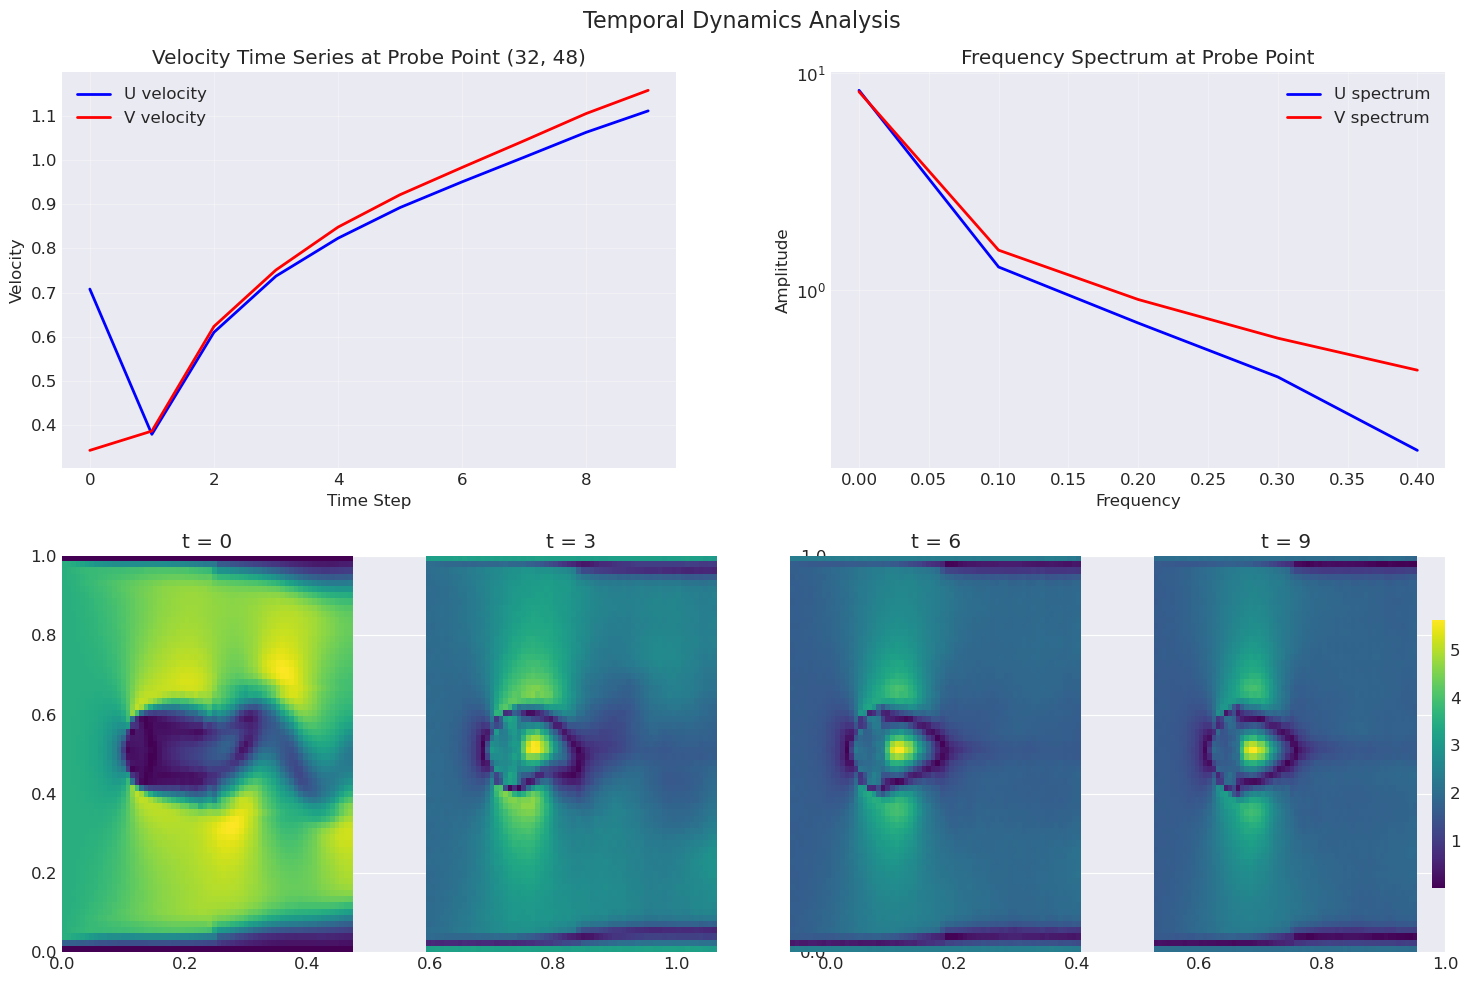


Dominant shedding frequency: 0.1000


In [10]:
# %% Analyze temporal evolution
def analyze_temporal_dynamics(model, val_loader, device, n_steps=10):
    """Analyze how well the model captures temporal dynamics"""
    
    model.eval()
    
    # Get a sequence of consecutive frames
    with torch.no_grad():
        for x_t, x_next in val_loader:
            x_t = x_t.to(device)
            x_sequence = [x_t]
            
            # Generate predictions
            current = x_t
            for _ in range(n_steps-1):
                current_cae = reshape_data_for_cae(current, 'cylinder', target_shape=target_resolution)
                
                if isinstance(model, CAE_WeakLinearMLP):
                    _, next_pred, _, _, _ = model(current_cae)
                else:
                    _, next_pred, _, _ = model(current_cae)
                
                # Reshape back
                next_pred_flat = next_pred.reshape(next_pred.shape[0], 2, -1)
                x_sequence.append(next_pred_flat)
                current = next_pred_flat
            
            break
    
    # Convert to numpy
    x_sequence = [x.cpu().numpy() for x in x_sequence]
    
    # Analyze specific location (probe point)
    probe_y = target_resolution[0] // 2
    probe_x = 3 * target_resolution[1] // 4  # Downstream of cylinder
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Time series at probe point
    ax = axes[0, 0]
    sample_idx = 0
    
    # Reshape sequences for probe analysis
    u_probe = []
    v_probe = []
    for t, x in enumerate(x_sequence):
        x_reshaped = x[sample_idx].reshape(2, *target_resolution)
        u_probe.append(x_reshaped[0, probe_y, probe_x])
        v_probe.append(x_reshaped[1, probe_y, probe_x])
    
    time_steps = np.arange(len(u_probe))
    ax.plot(time_steps, u_probe, 'b-', label='U velocity', linewidth=2)
    ax.plot(time_steps, v_probe, 'r-', label='V velocity', linewidth=2)
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Velocity')
    ax.set_title(f'Velocity Time Series at Probe Point ({probe_y}, {probe_x})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # FFT of probe signals
    ax = axes[0, 1]
    fft_u = np.fft.fft(u_probe)
    fft_v = np.fft.fft(v_probe)
    freqs = np.fft.fftfreq(len(u_probe))
    
    ax.semilogy(freqs[:len(freqs)//2], np.abs(fft_u[:len(freqs)//2]), 'b-', label='U spectrum', linewidth=2)
    ax.semilogy(freqs[:len(freqs)//2], np.abs(fft_v[:len(freqs)//2]), 'r-', label='V spectrum', linewidth=2)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    ax.set_title('Frequency Spectrum at Probe Point')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Visualize flow evolution
    time_indices = [0, 3, 6, 9]
    for idx, t_idx in enumerate(time_indices):
        if t_idx < len(x_sequence):
            ax = plt.subplot(2, 4, 5 + idx)
            x_t = x_sequence[t_idx][sample_idx].reshape(2, *target_resolution)
            velocity_mag = np.sqrt(x_t[0]**2 + x_t[1]**2)
            
            im = ax.imshow(velocity_mag, cmap='viridis', aspect='auto')
            ax.set_title(f't = {t_idx}')
            ax.axis('off')
            if idx == len(time_indices) - 1:
                plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.suptitle('Temporal Dynamics Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Calculate Strouhal number if vortex shedding is detected
    if len(np.abs(fft_v[:len(freqs)//2])) > 1:
        peak_freq_idx = np.argmax(np.abs(fft_v[1:len(freqs)//2])) + 1
        peak_freq = freqs[peak_freq_idx]
        print(f"\nDominant shedding frequency: {peak_freq:.4f}")

analyze_temporal_dynamics(model, val_loader, device, n_steps=10)

## 7. Multi-step Prediction Analysis

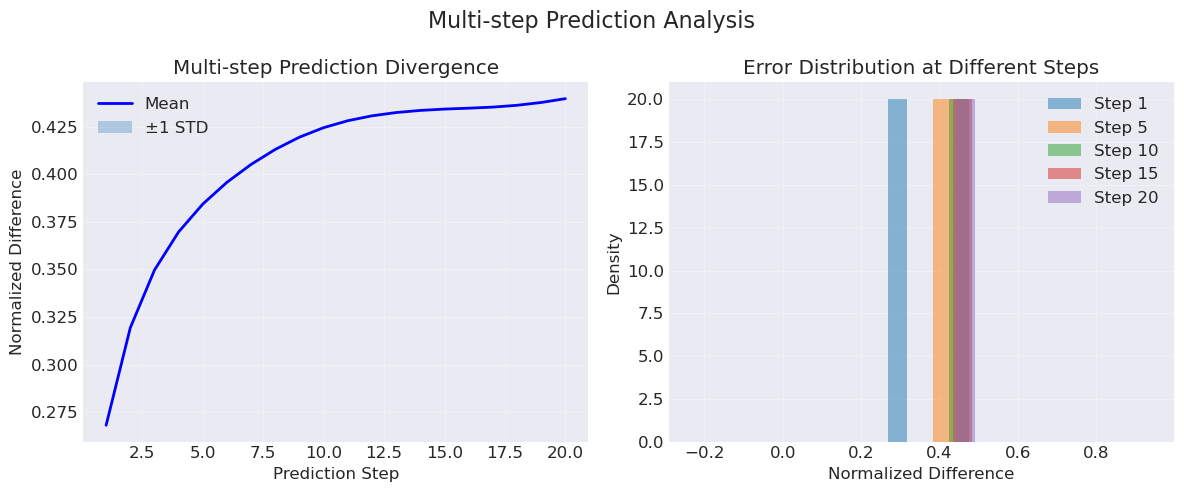


Multi-step Prediction Statistics:
Step 1: Mean = 0.2682, Std = 0.0000
Step 5: Mean = 0.3843, Std = 0.0000
Step 10: Mean = 0.4244, Std = 0.0000
Step 20: Mean = 0.4397, Std = 0.0000


In [12]:
# %% Evaluate multi-step predictions
def evaluate_multistep_predictions(model, val_loader, device, max_steps=20):
    """Evaluate prediction accuracy over multiple time steps"""
    
    model.eval()
    errors_by_step = {step: [] for step in range(1, max_steps+1)}
    
    with torch.no_grad():
        for batch_idx, (x_0, _) in enumerate(val_loader):
            if batch_idx >= 5:  # Evaluate on 5 batches
                break
                
            x_0 = x_0.to(device)
            current = x_0
            
            # Get ground truth sequence (would need sequential data loader)
            # For now, we'll analyze prediction divergence
            predictions = [current]
            
            for step in range(max_steps):
                current_cae = reshape_data_for_cae(current, 'cylinder', target_shape=target_resolution)
                
                if isinstance(model, CAE_WeakLinearMLP):
                    _, next_pred, _, _, _ = model(current_cae)
                else:
                    _, next_pred, _, _ = model(current_cae)
                
                # Reshape back
                next_pred_flat = next_pred.reshape(next_pred.shape[0], 2, -1)
                predictions.append(next_pred_flat)
                current = next_pred_flat
            
            # Analyze prediction stability
            for step in range(1, max_steps+1):
                pred = predictions[step]
                # Use first frame as reference (ideally would use true future frame)
                ref = predictions[0]
                
                # Compute normalized difference
                diff = torch.norm(pred - ref) / torch.norm(ref)
                errors_by_step[step].append(diff.item())
    
    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Mean error by step
    ax = axes[0]
    steps = list(errors_by_step.keys())
    mean_errors = [np.mean(errors_by_step[s]) for s in steps]
    std_errors = [np.std(errors_by_step[s]) for s in steps]
    
    ax.plot(steps, mean_errors, 'b-', linewidth=2, label='Mean')
    ax.fill_between(steps, 
                    np.array(mean_errors) - np.array(std_errors),
                    np.array(mean_errors) + np.array(std_errors),
                    alpha=0.3, label='±1 STD')
    ax.set_xlabel('Prediction Step')
    ax.set_ylabel('Normalized Difference')
    ax.set_title('Multi-step Prediction Divergence')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Distribution of errors at different steps
    ax = axes[1]
    selected_steps = [1, 5, 10, 15, 20]
    for step in selected_steps:
        if step in errors_by_step:
            ax.hist(errors_by_step[step], bins=20, alpha=0.5, label=f'Step {step}', density=True)
    
    ax.set_xlabel('Normalized Difference')
    ax.set_ylabel('Density')
    ax.set_title('Error Distribution at Different Steps')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('Multi-step Prediction Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print(f"\nMulti-step Prediction Statistics:")
    for step in [1, 5, 10, 20]:
        if step in errors_by_step:
            print(f"Step {step}: Mean = {np.mean(errors_by_step[step]):.4f}, "
                  f"Std = {np.std(errors_by_step[step]):.4f}")

evaluate_multistep_predictions(model, val_loader, device)

## 8. Reynolds Number Sensitivity Analysis

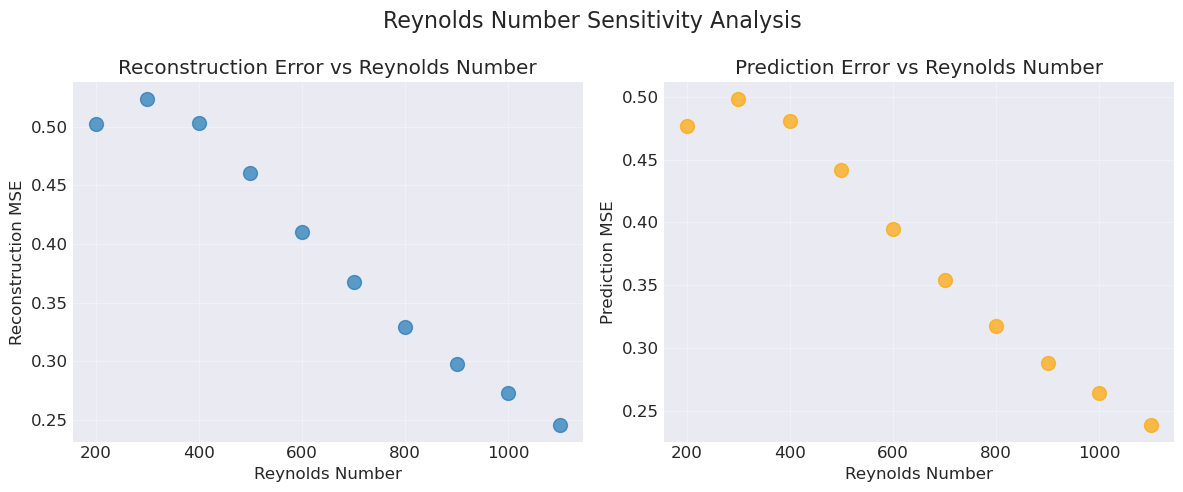


Reynolds Number Range: 200.0 - 1100.0
Reconstruction Error Range: 0.245325 - 0.524120
Prediction Error Range: 0.238613 - 0.498565

Correlation with Reynolds Number:
Reconstruction Error: r = -0.983, p = 0.000
Prediction Error: r = -0.981, p = 0.000


In [13]:
# %% Analyze model performance across different Reynolds numbers
def analyze_reynolds_sensitivity(model, data_path, device):
    """Analyze how model performs on different Reynolds numbers"""
    
    # Load case information
    import glob
    case_folders = sorted(glob.glob(str(data_path / "Cylinder" / "case*")))
    
    reynolds_numbers = []
    reconstruction_errors = []
    prediction_errors = []
    
    model.eval()
    
    for case_folder in case_folders[:10]:  # Analyze first 10 cases
        # Load case metadata
        case_json = Path(case_folder) / "case.json"
        if case_json.exists():
            with open(case_json, 'r') as f:
                case_data = json.load(f)
            
            # Calculate Reynolds number
            vel_in = case_data.get('vel_in', 0.3)
            density = case_data.get('density', 100)
            viscosity = case_data.get('viscosity', 0.1)
            diameter = 0.1  # Assume cylinder diameter
            
            Re = density * vel_in * diameter / viscosity
            reynolds_numbers.append(Re)
            
            # Load sample data from this case
            u_data = np.load(Path(case_folder) / "u.npy")
            v_data = np.load(Path(case_folder) / "v.npy")
            
            # Take a few time steps
            n_samples = min(10, u_data.shape[0] - 1)
            
            recon_errors = []
            pred_errors = []
            
            with torch.no_grad():
                for i in range(n_samples):
                    # Prepare data
                    x_t = np.stack([u_data[i], v_data[i]], axis=0)
                    x_next = np.stack([u_data[i+1], v_data[i+1]], axis=0)
                    
                    # Interpolate to target resolution
                    x_t_tensor = torch.from_numpy(x_t).float().unsqueeze(0).to(device)
                    x_next_tensor = torch.from_numpy(x_next).float().unsqueeze(0).to(device)
                    
                    # Resize if needed
                    if x_t_tensor.shape[-2:] != target_resolution:
                        x_t_tensor = torch.nn.functional.interpolate(
                            x_t_tensor, size=target_resolution, mode='bilinear', align_corners=False
                        )
                        x_next_tensor = torch.nn.functional.interpolate(
                            x_next_tensor, size=target_resolution, mode='bilinear', align_corners=False
                        )
                    
                    # Get predictions
                    if isinstance(model, CAE_WeakLinearMLP):
                        x_t_recon, x_next_pred, _, _, _ = model(x_t_tensor)
                    else:
                        x_t_recon, x_next_pred, _, _ = model(x_t_tensor)
                    
                    # Calculate errors
                    recon_error = nn.MSELoss()(x_t_recon, x_t_tensor).item()
                    pred_error = nn.MSELoss()(x_next_pred, x_next_tensor).item()
                    
                    recon_errors.append(recon_error)
                    pred_errors.append(pred_error)
            
            reconstruction_errors.append(np.mean(recon_errors))
            prediction_errors.append(np.mean(pred_errors))
    
    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Reconstruction error vs Re
    ax = axes[0]
    ax.scatter(reynolds_numbers, reconstruction_errors, s=100, alpha=0.7)
    ax.set_xlabel('Reynolds Number')
    ax.set_ylabel('Reconstruction MSE')
    ax.set_title('Reconstruction Error vs Reynolds Number')
    ax.grid(True, alpha=0.3)
    
    # Prediction error vs Re
    ax = axes[1]
    ax.scatter(reynolds_numbers, prediction_errors, s=100, alpha=0.7, color='orange')
    ax.set_xlabel('Reynolds Number')
    ax.set_ylabel('Prediction MSE')
    ax.set_title('Prediction Error vs Reynolds Number')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('Reynolds Number Sensitivity Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nReynolds Number Range: {min(reynolds_numbers):.1f} - {max(reynolds_numbers):.1f}")
    print(f"Reconstruction Error Range: {min(reconstruction_errors):.6f} - {max(reconstruction_errors):.6f}")
    print(f"Prediction Error Range: {min(prediction_errors):.6f} - {max(prediction_errors):.6f}")
    
    # Correlation analysis
    from scipy.stats import pearsonr
    corr_recon, p_recon = pearsonr(reynolds_numbers, reconstruction_errors)
    corr_pred, p_pred = pearsonr(reynolds_numbers, prediction_errors)
    
    print(f"\nCorrelation with Reynolds Number:")
    print(f"Reconstruction Error: r = {corr_recon:.3f}, p = {p_recon:.3f}")
    print(f"Prediction Error: r = {corr_pred:.3f}, p = {p_pred:.3f}")

# Analyze Reynolds sensitivity
data_path = Path(project_root) / 'data'
analyze_reynolds_sensitivity(model, data_path, device)

## 9. Model Dynamics Analysis (for Linear Models)

In [14]:
# %% Analyze linear dynamics
if isinstance(model, CAE_LinearMLP):
    # Get the linear transformation matrix
    A = model.dynamics.get_weight_matrix().detach().cpu().numpy()
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Visualize the matrix
    ax = axes[0, 0]
    im = ax.imshow(A, cmap='RdBu_r', aspect='equal')
    ax.set_title('Linear Dynamics Matrix A')
    ax.set_xlabel('Input Dimension')
    ax.set_ylabel('Output Dimension')
    plt.colorbar(im, ax=ax)
    
    # Eigenvalue analysis
    eigenvalues, eigenvectors = np.linalg.eig(A)
    
    ax = axes[0, 1]
    ax.scatter(eigenvalues.real, eigenvalues.imag, alpha=0.6, s=50)
    circle = plt.Circle((0, 0), 1, fill=False, color='red', linestyle='--', linewidth=2)
    ax.add_patch(circle)
    ax.set_xlabel('Real Part')
    ax.set_ylabel('Imaginary Part')
    ax.set_title('Eigenvalues of Dynamics Matrix')
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    
    # Eigenvalue magnitudes
    ax = axes[0, 2]
    eig_mags = np.abs(eigenvalues)
    ax.hist(eig_mags, bins=30, alpha=0.7, edgecolor='black')
    ax.axvline(1.0, color='red', linestyle='--', label='Unit circle', linewidth=2)
    ax.set_xlabel('Eigenvalue Magnitude')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Eigenvalue Magnitudes')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Top eigenvalues by magnitude
    ax = axes[1, 0]
    top_k = 20
    sorted_indices = np.argsort(eig_mags)[::-1]
    top_eigs = eigenvalues[sorted_indices[:top_k]]
    
    ax.scatter(range(top_k), eig_mags[sorted_indices[:top_k]], s=50)
    ax.axhline(1.0, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Eigenvalue Index')
    ax.set_ylabel('Magnitude')
    ax.set_title(f'Top {top_k} Eigenvalues by Magnitude')
    ax.grid(True, alpha=0.3)
    
    # Frequency analysis of eigenvalues
    ax = axes[1, 1]
    # Extract frequencies from complex eigenvalues
    frequencies = []
    for eig in eigenvalues:
        if np.abs(eig.imag) > 1e-6:  # Complex eigenvalue
            freq = np.abs(eig.imag) / (2 * np.pi)
            frequencies.append(freq)
    
    if frequencies:
        ax.hist(frequencies, bins=20, alpha=0.7, edgecolor='black')
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Count')
        ax.set_title('Oscillation Frequencies from Eigenvalues')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No oscillatory modes detected', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Oscillation Frequencies')
    
    # Singular values
    ax = axes[1, 2]
    singular_values = np.linalg.svd(A, compute_uv=False)
    ax.semilogy(singular_values, 'bo-', linewidth=2, markersize=4)
    ax.set_xlabel('Index')
    ax.set_ylabel('Singular Value')
    ax.set_title('Singular Values of Dynamics Matrix')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('Linear Dynamics Analysis for Cylinder Flow', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nLinear Dynamics Statistics:")
    print(f"Matrix condition number: {np.linalg.cond(A):.4f}")
    print(f"Stable eigenvalues (|λ| ≤ 1): {np.sum(eig_mags <= 1)}/{len(eig_mags)}")
    print(f"Largest eigenvalue magnitude: {np.max(eig_mags):.4f}")
    print(f"Number of oscillatory modes: {len(frequencies)}")
    if frequencies:
        print(f"Dominant frequency: {max(frequencies):.4f}")

## 10. Summary and Conclusions

KeyError: 'total'

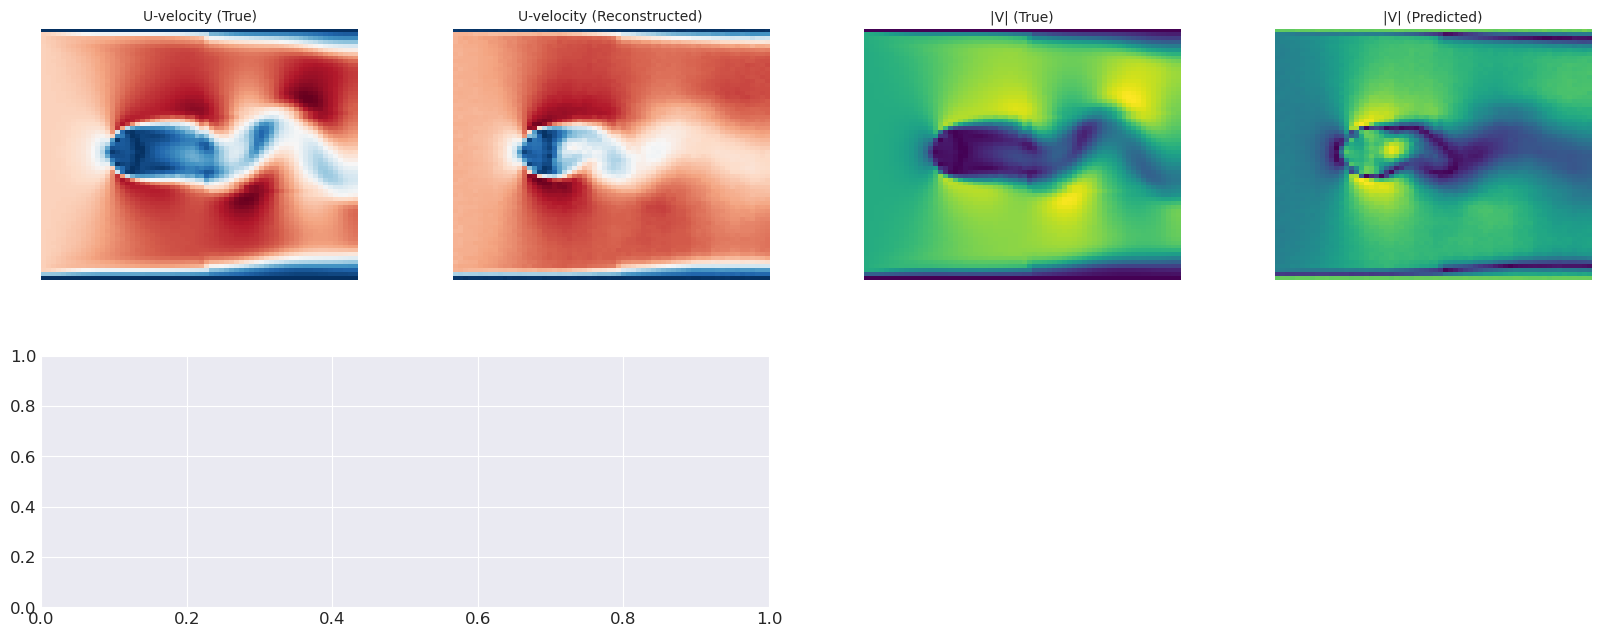

In [15]:
# %% Create summary visualization
def create_cylinder_summary_figure(model, x_t_cae, x_t_recon, x_next_cae, x_next_pred, 
                                  losses_data, config, save_path):
    """Create a comprehensive summary figure for cylinder flow analysis"""
    
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    # 1. Flow reconstruction
    ax1 = fig.add_subplot(gs[0, 0])
    u_true = x_t_cae[0, 0].cpu().numpy()
    im1 = ax1.imshow(u_true, cmap='RdBu_r', aspect='auto')
    ax1.set_title('U-velocity (True)', fontsize=10)
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[0, 1])
    u_recon = x_t_recon[0, 0].cpu().numpy()
    im2 = ax2.imshow(u_recon, cmap='RdBu_r', aspect='auto')
    ax2.set_title('U-velocity (Reconstructed)', fontsize=10)
    ax2.axis('off')
    
    # 2. Velocity magnitude
    ax3 = fig.add_subplot(gs[0, 2])
    mag_true = np.sqrt(x_t_cae[0, 0].cpu().numpy()**2 + x_t_cae[0, 1].cpu().numpy()**2)
    im3 = ax3.imshow(mag_true, cmap='viridis', aspect='auto')
    ax3.set_title('|V| (True)', fontsize=10)
    ax3.axis('off')
    
    ax4 = fig.add_subplot(gs[0, 3])
    mag_pred = np.sqrt(x_next_pred[0, 0].cpu().numpy()**2 + x_next_pred[0, 1].cpu().numpy()**2)
    im4 = ax4.imshow(mag_pred, cmap='viridis', aspect='auto')
    ax4.set_title('|V| (Predicted)', fontsize=10)
    ax4.axis('off')
    
    # 3. Training curves
    ax5 = fig.add_subplot(gs[1, :2])
    if config['training']['train_mode'] == 'separately':
        epochs1 = range(len(losses_data['train_losses']['stage1']['reconstruction']))
        ax5.plot(epochs1, losses_data['train_losses']['stage1']['reconstruction'], 
                'b-', label='Stage 1 Train', linewidth=2)
        ax5.plot(epochs1, losses_data['val_losses']['stage1']['reconstruction'], 
                'b--', label='Stage 1 Val', linewidth=2)
        ax5.set_yscale('log')
    else:
        ax5.plot(losses_data['train_losses']['total'], label='Train', linewidth=2)
        ax5.plot(losses_data['val_losses']['total'], label='Val', linewidth=2)
        ax5.set_yscale('log')
    
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Loss')
    ax5.set_title('Training Progress')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 4. Vorticity
    ax6 = fig.add_subplot(gs[1, 2:])
    vort_true = compute_vorticity(x_t_cae[0, 0].cpu().numpy(), x_t_cae[0, 1].cpu().numpy())
    vort_recon = compute_vorticity(x_t_recon[0, 0].cpu().numpy(), x_t_recon[0, 1].cpu().numpy())
    
    vmax = np.abs(vort_true).max()
    im6 = ax6.imshow(vort_true, cmap='RdBu_r', vmin=-vmax, vmax=vmax, aspect='auto')
    ax6.set_title('Vorticity Field', fontsize=10)
    ax6.axis('off')
    plt.colorbar(im6, ax=ax6, fraction=0.046)
    
    # 5. Performance metrics
    ax7 = fig.add_subplot(gs[2:, :])
    ax7.axis('off')
    
    # Calculate metrics
    mse_recon = nn.MSELoss()(x_t_recon, x_t_cae).item()
    mse_pred = nn.MSELoss()(x_next_pred, x_next_cae).item()
    rel_error_recon = torch.norm(x_t_recon - x_t_cae) / torch.norm(x_t_cae)
    rel_error_pred = torch.norm(x_next_pred - x_next_cae) / torch.norm(x_next_cae)
    
    metrics_text = f"""
    Cylinder Flow Analysis Summary
    
    Model Configuration:
    • Model Type: {config['model']['type']}
    • Training Mode: {config['training']['train_mode']}
    • Latent Dimension: {config['model']['params']['latent_dim']}
    • Target Resolution: {target_resolution}
    
    Performance Metrics:
    • Reconstruction MSE: {mse_recon:.6f}
    • Reconstruction Relative Error: {rel_error_recon:.2%}
    • Prediction MSE: {mse_pred:.6f}
    • Prediction Relative Error: {rel_error_pred:.2%}
    
    Flow Characteristics:
    • Number of velocity components: 2 (u, v)
    • Spatial resolution: {target_resolution[0]} × {target_resolution[1]}
    • Vorticity preservation: {1 - np.mean((vort_true - vort_recon)**2) / np.mean(vort_true**2):.2%}
    """
    
    ax7.text(0.1, 0.9, metrics_text, fontsize=12, 
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
             transform=ax7.transAxes)
    
    plt.suptitle(f'CAE-MLP Model Analysis: Cylinder Flow\n{experiment_folder}', 
                 fontsize=16, fontweight='bold')
    
    # Save figure
    save_path = Path(save_path)
    fig_path = save_path / 'cylinder_analysis_summary.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.savefig(save_path / 'cylinder_analysis_summary.pdf', bbox_inches='tight')
    plt.show()
    
    print(f"Summary figure saved to: {fig_path}")

# Create summary figure
create_cylinder_summary_figure(model, x_t_cae, x_t_recon, x_next_cae, x_next_pred,
                              losses_data, config, experiment_path)


In [17]:
analysis_results = {
    'experiment_path': str(experiment_path),
    'model_type': config['model']['type'],
    'training_mode': config['training']['train_mode'],
    'latent_dim': config['model']['params']['latent_dim'],
    'target_resolution': list(target_resolution),
    'performance_metrics': {
        'reconstruction_mse': float(nn.MSELoss()(x_t_recon, x_t_cae).item()),
        'reconstruction_relative_error': float(torch.norm(x_t_recon - x_t_cae) / torch.norm(x_t_cae)),
        'prediction_mse': float(nn.MSELoss()(x_next_pred, x_next_cae).item()),
        'prediction_relative_error': float(torch.norm(x_next_pred - x_next_cae) / torch.norm(x_next_cae))
    }
}

# Save to JSON
analysis_path = experiment_path / 'cylinder_analysis_results.json'
with open(analysis_path, 'w') as f:
    json.dump(analysis_results, f, indent=4)

print(f"\nAnalysis results saved to: {analysis_path}")


Analysis results saved to: /rds/general/user/wy524/home/ESEProjects/IRP/irp-test-framework/results/checkpoints/CAE_MLP/cylinder_CAE_WeakLinearMLP_multiply_large_epoch/cylinder_analysis_results.json


In [18]:
print("\nNotebook execution completed successfully!")
print(f"All results saved to: {experiment_path}")


Notebook execution completed successfully!
All results saved to: /rds/general/user/wy524/home/ESEProjects/IRP/irp-test-framework/results/checkpoints/CAE_MLP/cylinder_CAE_WeakLinearMLP_multiply_large_epoch
